In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle, FancyArrowPatch
from mpl_toolkits.axes_grid1 import make_axes_locatable
import magpylib as magpy
import plotly.graph_objects as go
from mayavi import mlab

In [2]:
plt.style.use("matplotlib_hackaday.mplstyle")
mlab.init_notebook('png')

Notebook initialized with png backend.


In [3]:
# Repero FS17 450/750 V
# https://www.baldassaricavi.it/wp-content/uploads/2019/10/2-FS-17..pdf

df_cable = np.array([
    ["1x1","1x1.5", "1x2.5", "1x4", "1x6", "1x10"],
    [1.3, 1.6, 1.9, 2.5, 3.0, 4.0], # conductor diameter (mm)
    [0.7, 0.7, 0.8, 0.8, 1.0, 1.0], # insulator thickness (mm)
    [2.7, 2.9, 3.6, 4.2, 4.6, 6.0], # wire diameter (mm)
    [15, 20, 31, 45, 63, 109], # cable weight (kg/km)
    [19.5, 13.3, 7.68, 4.95, 3.30, 1.91], # resistance @20°C (ohm/km)
    [12, 16, 21, 28, 36, 50] # current rating @30°C (A)
])

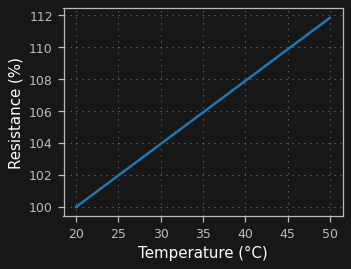

In [4]:
# resistance with temperature
# 
#   R = R_0*[1+ alpha_0(t-t_0)]
#
# but alpha change with temp
fig, ax= plt.subplots(1, 1, figsize=(4, 3), dpi=90)
a_20 = 0.00394
dt = 1  # °C
T = np.arange(20, 50+dt, dt)

# costant alpha 
R_cost = 1+a_20*(T-20)

ax.plot(T, 100*R_cost, linewidth=2)
ax.grid()
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Resistance (%)")
plt.show()


In [5]:
# Pwer supply spec
PS_curr = 20
PS_vpp = 24

# Cycle over radius and cables

In [6]:
# cicle through wires types

sensor = magpy.Sensor()

r_min = 65 # mm
l_max = 120 # mm

size = 30
L = 90
ts = np.linspace(-L, L, size)
# X, Y = np.meshgrid(ts, ts)
grid = np.array([(x, 0, 0) for x in ts])

# R = 90 # mm
rad_mat = []

r_list = [80, 90, 100]

for R in r_list:
    coils = []
    B_list = []
    B_center_list = []
    w_d_list = []
    w_tot_l_list = []
    w_vpp_list = []
    w_P_list = []
    w_R_list = []
    w_curr_list = []

    for w in df_cable.T:
        w_d = float(w[3])
        w_d_list.append(w_d)
        w_rho = float(w[5])
        w_curr = float(w[-1])
        w_curr = w_curr if w_curr <= PS_curr else PS_curr
        r_max = 2*R-r_min
        max_r_turns = 2*int((R-65)/w_d)
        r_turn = max_r_turns
        x_turn = max_r_turns
        start_r = R-((r_turn-1)/2)*w_d
        end_r = start_r+(r_turn-1)*w_d
        start_x = R/2-((x_turn-1)/2)*w_d
        end_x = start_x+(x_turn-1)*w_d
        r_wires = np.arange(start_r, end_r+w_d, w_d)
        x_wires = np.arange(start_x, end_x+w_d, w_d)
        
        coils = []

        # electronic properties
        w_tot_l = 0

        for r in r_wires:
            w_tot_l+=x_turn*2*2*np.pi*r

        w_R = w_rho*w_tot_l/1e6 # (ohm/km)
        w_vpp = w_R*w_curr

        # POWER SUPPLY RANGE 24V 20A 
        if w_vpp >= PS_vpp:
            w_vpp = PS_vpp
            w_curr = w_vpp/w_R
        
        w_curr_list.append(w_curr)

        w_P = w_curr*w_vpp

        w_tot_l_list.append(w_tot_l/1000.)
        w_vpp_list.append(w_vpp)
        w_P_list.append(w_P)
        w_R_list.append(w_R)


        for x in x_wires:
            for r in r_wires:
                coils.append(magpy.current.Loop(current=w_curr, diameter=2*r, position=(0, 0, x)))
                coils.append(magpy.current.Loop(current=w_curr, diameter=2*r, position=(0, 0, -x)))

        total_coil = coils[0]
        for i in coils[1:]:
            total_coil+=i
        
        B = total_coil.getB(grid)
        B_center = total_coil.getB(sensor)[2]

        # magnetic field 
        B_list.append(B[:,2])
        B_center_list.append(B_center)

    B_list = np.array(B_list) 
    B_center_list = np.array(B_center_list) 
    w_d_list = np.array(w_d_list) 
    w_tot_l_list = np.array(w_tot_l_list) 
    w_vpp_list = np.array(w_vpp_list) 
    w_P_list = np.array(w_P_list) 
    w_R_list = np.array(w_R_list) 
    w_curr_list = np.array(w_curr_list) 

    rad_mat.append([B_list,B_center_list,w_d_list,w_tot_l_list,w_vpp_list,w_P_list,w_R_list,w_curr_list])

# rad_mat = np.array(rad_mat)

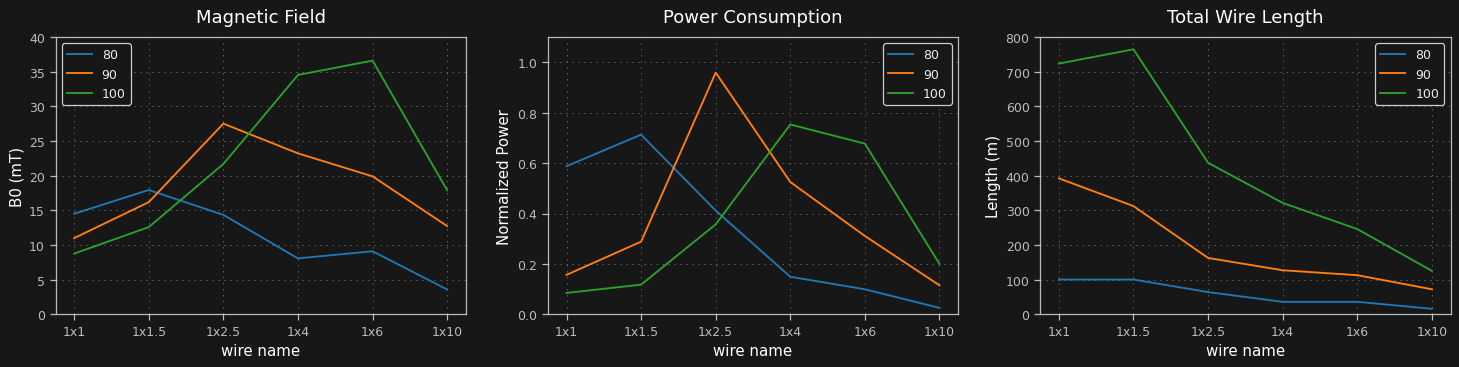

In [7]:
fig = plt.figure(figsize=(20, 4), dpi=90)

ax = plt.subplot(131)
for set, r in zip(rad_mat, r_list):
    B_list, B_center_list, w_d_list, w_tot_l_list, w_vpp_list, w_P_list, w_R_list, w_curr_list = set
    ax.plot(df_cable[0], B_center_list, label=str(r))
ax.grid()
ax.set_ylim([0, 40]) 
ax.legend()
ax.set_xlabel("wire name")
ax.set_ylabel("B0 (mT)")
ax.set_title("Magnetic Field")

ax = plt.subplot(132)
for set, r in zip(rad_mat, r_list):
    B_list, B_center_list, w_d_list, w_tot_l_list, w_vpp_list, w_P_list, w_R_list, w_curr_list = set
    ax.plot(df_cable[0], w_P_list/PS_vpp/PS_curr, label=str(r))
ax.grid()
ax.set_ylim([0, 1.1])
ax.legend()
ax.set_xlabel("wire name")
ax.set_ylabel("Normalized Power")
ax.set_title("Power Consumption")

ax = plt.subplot(133)
# homo_rad = []
# for i, b, b_c in zip(df_cable[0], B_list, B_center_list):
#     err = (b_c-b)/b_c
#     err_tr = (err<0.01)*1
#     err_tr = err_tr-np.roll(err_tr, 1)
#     bounds = ts[np.nonzero(err_tr)]
#     homo_rad.append(bounds[1]-bounds[0])
for set, r in zip(rad_mat, r_list):
    B_list, B_center_list, w_d_list, w_tot_l_list, w_vpp_list, w_P_list, w_R_list, w_curr_list = set
    ax.plot(df_cable[0], w_tot_l_list, label=str(r))
ax.grid()   
ax.set_ylim([0, 800])
ax.legend()
ax.set_xlabel("wire name")
ax.set_ylabel("Length (m)")
ax.set_title("Total Wire Length")

plt.show()

In [6]:
name, cond_d, _, wire_d, _, wire_rho, wire_max_curr = df_cable.T[2] # BEST 1x2.5
cond_d =float(cond_d)
wire_d = float(wire_d)
wire_rho = float(wire_rho)
wire_max_curr = float(wire_max_curr)
name, cond_d, _, wire_d, _, wire_rho, wire_max_curr

wire_curr = wire_max_curr if wire_max_curr <= PS_curr else PS_curr
wire_curr

20

In [7]:
r_min = 65 # mm
l_max = 120 # mm

R = 90 #mm   # BEST
r_max = 2*R-r_min

max_r_turns = 2*int((R-65)/wire_d)

r_turn = max_r_turns
x_turn = r_turn

start_r = R-((r_turn-1)/2)*wire_d
end_r = start_r+(r_turn-1)*wire_d    

start_x = R/2-((x_turn-1)/2)*wire_d
end_x = start_x+(x_turn-1)*wire_d
print("Turns:", max_r_turns)

Turns: 12


In [8]:
r_wires = np.arange(start_r, end_r+wire_d, wire_d)
x_wires = np.arange(start_x, end_x+wire_d, wire_d)

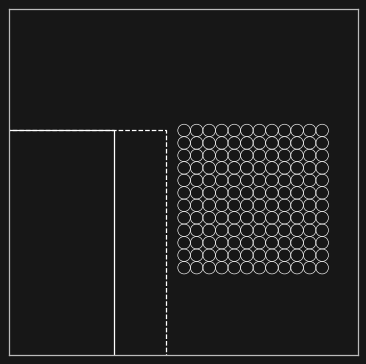

In [9]:
fig, ax = plt.subplots(1, 1, dpi=90, figsize=(5, 5))

ax.add_patch(Rectangle((-65, -65), 130, 130, fill=False, linestyle="--", color="white"))
ax.add_patch(Rectangle((-50, -65), 100, 130, fill=False, color="white"))
for x in x_wires:
    for r in r_wires:
        ax.add_patch(Circle((r, x), radius=wire_d/2., fill=False, color="white", linewidth=0.5))
        # ax.add_patch(Circle((r, -x), radius=wire_d/2., fill=False, color="white", linewidth=0.5))
        # ax.add_patch(Circle((-r, x), radius=wire_d/2., fill=False, color="white", linewidth=0.5))
        # ax.add_patch(Circle((-r, -x), radius=wire_di/2., fill=False, color="white", linewidth=0.5))
        
c = [70, 50]
s = 50
ax.set_xlim([c[0]-s, c[0]+s])
ax.set_ylim([c[1]-s, c[1]+s])
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [10]:
start_r, end_r, end_r-start_r

(70.2, 109.80000000000001, 39.60000000000001)

In [11]:
# electronic properties
tot_l = 0

for r in r_wires:
    tot_l+=x_turn*2*2*np.pi*r

wire_R = wire_rho*tot_l/1e6 # (ohm/km)
wire_vpp = wire_R*wire_max_curr
wire_curr = wire_max_curr

# # POWER SUPPLY RANGE 24V 20A 
if wire_vpp > PS_vpp:
    wire_vpp = PS_vpp
    wire_curr = wire_vpp/wire_R


In [12]:
tot_l = 0

for r in r_wires:
    tot_l+=x_turn*2*2*np.pi*r

print(f"Wire length: {tot_l/1000:.0f} m")
print(f"Wire Resistance: {wire_R:.3f} Ohm")
print(f"Max Current Rating: {wire_curr:.0f} A")
print(f"Voltage: {wire_vpp:.1f} V")
print(f"Power: {wire_vpp*wire_curr:.0f} W")

Wire length: 163 m
Wire Resistance: 1.251 Ohm
Max Current Rating: 19 A
Voltage: 24.0 V
Power: 461 W


In [19]:
# my version
def plot_circle(R, xyz0):
    x0, y0, z0 = xyz0
    angle = np.linspace(0, 2*np.pi, 50)
    x = x0+R*np.sin(angle)
    y = y0+R*np.cos(angle)
    z = z0+0.*angle
    return x, y, z
    # mlab.plot3d(x, y, z, color=(1,0,0), tube_radius=0.1)


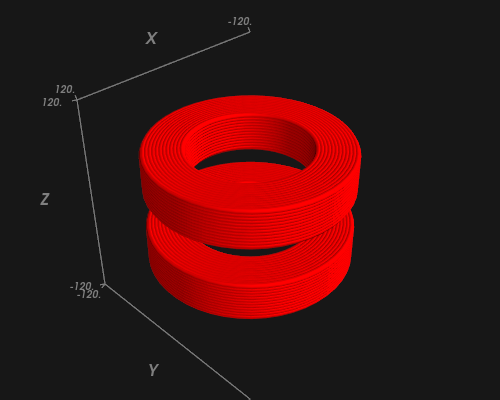

In [48]:
l = 120
# mlab.plot3d(x, y, z, color=(0,0,1), tube_radius=0.1)
f = mlab.figure(bgcolor=(23./255, 23./255, 23./255), fgcolor=(.5, .5, .5), size=(500, 400))

# surf = mlab.plot3d(*plot_circle(r, [0, 0, x]), color=(1,0,0), tube_radius=wire_d, figure=f)
# surf1 = mlab.plot3d(*plot_circle(r, [0, 0, -x]), color=(1,0,0), tube_radius=wire_d, figure=f)
for i, r in enumerate(r_wires):
    for j, x in enumerate(x_wires):
        if i==0 or i==len(r_wires)-1:
            mlab.plot3d(*plot_circle(r, [0, 0, x]), color=(1,0,0), tube_radius=wire_d)
            mlab.plot3d(*plot_circle(r, [0, 0, -x]), color=(1,0,0), tube_radius=wire_d)
        else:
            if j==0 or j==len(x_wires)-1:
                mlab.plot3d(*plot_circle(r, [0, 0, x]), color=(1,0,0), tube_radius=wire_d)
                mlab.plot3d(*plot_circle(r, [0, 0, -x]), color=(1,0,0), tube_radius=wire_d)
mlab.points3d([-l,l], [-l,l], [-l,l], scale_factor=0.0001)
mlab.axes(figure=f)
f

In [124]:
coils = []

for x in x_wires:
    for r in r_wires:
        coils.append(magpy.current.Loop(current=wire_curr, diameter=2*r, position=(0, 0, x)))
        coils.append(magpy.current.Loop(current=wire_curr, diameter=2*r, position=(0, 0, -x)))

total_coil = coils[0]
for i in coils[1:]:
    total_coil+=i

sensor = magpy.Sensor()

size = 300
L = 80
ts = np.linspace(-L, L, size)
X, Y = np.meshgrid(ts, ts)
grid = np.array([[(x, 0, z) for x in ts] for z in ts])


In [66]:
B = total_coil.getB(grid)

In [67]:
gamma_h = 42.5756 # MHz/T
b_z_earth = 65E-6 # T

In [68]:
B_center = total_coil.getB(sensor)[2]
print(f"Magnetic Field at Center:   {B_center:.2f} mT")
B_homo = np.ones((size, size))*B_center

print(f"Coil vs Earth ratio B0/B_earth:   {B_center/1000/b_z_earth:.2f}")
freq = gamma_h*B_center
print(f"Working Resonance Frequency:   {freq:.2f} kHz")

Magnetic Field at Center:   27.52 mT
Coil vs Earth ratio B0/B_earth:   423.45
Working Resonance Frequency:   1171.85 kHz


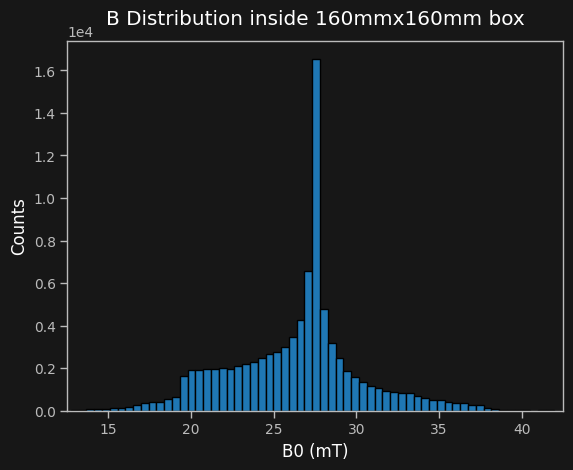

In [173]:
plt.hist(B[:,:,2].flatten(), bins=100, edgecolor='black')
plt.xlim([B_center-15, B_center+15])
plt.xlabel("B0 (mT)")
plt.ylabel("Counts")
plt.title(f"B Distribution inside {2*L}mmx{2*L}mm box")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.show()

In [71]:
B[B[:,:,2]<(B_center-20)] = 0
B[B[:,:,2]>(B_center+20)] = 0

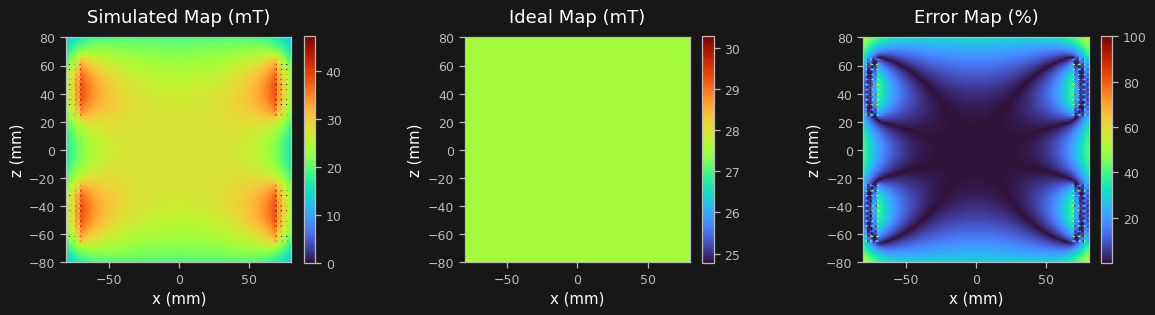

In [148]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6), dpi=90)

ax1.set_aspect(1)
ax2.set_aspect(1)
ax3.set_aspect(1)

p = ax1.pcolor(X, Y, B[:,:,2], cmap='turbo')
plt.colorbar(p,fraction=0.0455)
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("z (mm)")
ax1.set_title("Simulated Map (mT)")

p = ax2.pcolor(X, Y, B_homo, cmap='turbo')
plt.colorbar(p,fraction=0.0455)
ax2.set_xlabel("x (mm)")
ax2.set_ylabel("z (mm)")
ax2.set_title("Ideal Map (mT)")


err = np.abs(B[:,:,2]-B_homo)/B_center
p = ax3.pcolor(X, Y, err*100, cmap='turbo')
plt.colorbar(p,fraction=0.0455)
ax3.set_xlabel("x (mm)")
ax3.set_ylabel("z (mm)")
ax3.set_title("Error Map (%)")

plt.subplots_adjust(wspace=0.6)
plt.show()

In [95]:
# create custom cmap
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap

cmap = pl.cm.Greys
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = np.linspace(1, 0, cmap.N)
my_cmap_alpha = ListedColormap(my_cmap)

cmap = pl.cm.jet
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1]*= 1.0
my_cmap_jet = ListedColormap(my_cmap)

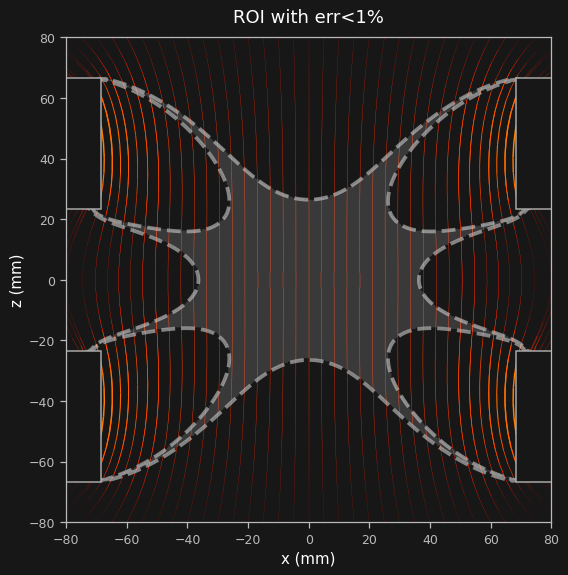

In [147]:
err_thr = 0.01
err_map_thr = err<err_thr

fig, ax = plt.subplots(1, 1, dpi=90, figsize=(7, 7))
ax.set_aspect(1)

B_norm = (B[:,:,2]-np.min(B[:,:,2]))/(np.max(B[:,:,2])-np.min(B[:,:,2]))
l = ax.streamplot(
    grid[:,:,0], grid[:,:,2], B[:,:,0], B[:,:,2],
    color=np.power(B_norm, 3),
    linewidth=np.power(B_norm, 4)*3,
    density=1.1,
    cmap="autumn",
    zorder=-2,
    arrowsize=0,
    broken_streamlines=False
)

ax.imshow(1-err_map_thr, cmap=my_cmap_alpha, alpha=0.15, extent=[-L, L, -L, L], zorder=-2)
ax.contour(X, Y, err, levels=[0.01], zorder=-1, linewidths=3,alpha=0.6, colors="#ccc", linestyles="dashed")

ax.set_xlabel("x (mm)")
ax.set_ylabel("z (mm)")
ax.set_title("ROI with err<1%")
ax.add_patch(Rectangle([start_r-0.5*wire_d, start_x-0.5*wire_d], (r_turn)*wire_d, (x_turn)*wire_d, 
                       facecolor="#171717", edgecolor="#aaa", lw=1.2))
ax.add_patch(Rectangle([start_r-0.5*wire_d, -(start_x-0.5*wire_d)], (r_turn)*wire_d, -(x_turn)*wire_d, 
                       facecolor="#171717", edgecolor="#aaa", lw=1.2))
ax.add_patch(Rectangle([-(start_r-0.5*wire_d), start_x-0.5*wire_d], -(r_turn)*wire_d, (x_turn)*wire_d, 
                       facecolor="#171717", edgecolor="#aaa", lw=1.2))
ax.add_patch(Rectangle([-(start_r-0.5*wire_d), -(start_x-0.5*wire_d)], -(r_turn)*wire_d, -(x_turn)*wire_d, 
                       facecolor="#171717", edgecolor="#aaa", lw=1.2))
# ax.add_patch(Rectangle((-50, -65), 100, 130, fill=False, color="#3f81eb", zorder=5, lw=2))
# ax.add_patch(Circle((0, 0), 35))
plt.xlim([-L, L])
plt.show()